## Load Data from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzip data from drive into train and test folder

In [0]:
! mkdir test
! unzip -qq drive/My\ Drive/intel_scene/train-scene\ classification.zip -d train/
! cp drive/My\ Drive/intel_scene/test_WyRytb0.csv test/ #CSV also availabe here https://github.com/difference-engine/intel-scene-data

## Seperate test images into train/test folder

In [0]:
import shutil
import pandas as pd
test_df = pd.read_csv('test/test_WyRytb0.csv')
!mkdir train/test
[shutil.copy('train/train/'+ i, 'train/test') for i in test_df['image_name'].tolist()]

['train/test/3.jpg',
 'train/test/5.jpg',
 'train/test/6.jpg',
 'train/test/11.jpg',
 'train/test/14.jpg',
 'train/test/22.jpg',
 'train/test/25.jpg',
 'train/test/28.jpg',
 'train/test/30.jpg',
 'train/test/38.jpg',
 'train/test/51.jpg',
 'train/test/52.jpg',
 'train/test/61.jpg',
 'train/test/63.jpg',
 'train/test/64.jpg',
 'train/test/69.jpg',
 'train/test/70.jpg',
 'train/test/72.jpg',
 'train/test/73.jpg',
 'train/test/76.jpg',
 'train/test/77.jpg',
 'train/test/79.jpg',
 'train/test/81.jpg',
 'train/test/84.jpg',
 'train/test/88.jpg',
 'train/test/93.jpg',
 'train/test/99.jpg',
 'train/test/101.jpg',
 'train/test/103.jpg',
 'train/test/110.jpg',
 'train/test/117.jpg',
 'train/test/119.jpg',
 'train/test/121.jpg',
 'train/test/126.jpg',
 'train/test/127.jpg',
 'train/test/129.jpg',
 'train/test/130.jpg',
 'train/test/132.jpg',
 'train/test/133.jpg',
 'train/test/135.jpg',
 'train/test/140.jpg',
 'train/test/141.jpg',
 'train/test/143.jpg',
 'train/test/144.jpg',
 'train/test/145.j

## We need resnet50_places365 model, lets download it

In [2]:
! wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar

--2019-04-01 12:11:26--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.30.100.255
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.30.100.255|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘resnet50_places365.pth.tar.2’

resnet50_places365. 100%[===================>]  92.76M  82.6MB/s    in 1.1s    

2019-04-01 12:11:28 (82.6 MB/s) - ‘resnet50_places365.pth.tar.2’ saved [97270159/97270159]



## Fast.ai implmentation

In [0]:
import fastai
from fastai import *
from fastai.vision import *

In [0]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

random_seed(42, True)

In [0]:
image_path = 'train/'
image_folder = 'train/'
train_csv = 'train.csv'
test_image_folder = 'test/'
test_csv = 'test_WyRytb0.csv'

In [4]:
data = ImageDataBunch.from_csv(path=image_path, 
                               folder=image_folder, 
                               csv_labels=train_csv, 
                               label_col=1, bs=32, 
                               test= test_image_folder, 
                               size=224, 
                               num_workers=4, 
                               ds_tfms=get_transforms())
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
4,5,4,1,5
Path: train;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,0,0,0,1
Path: train;

Test: LabelList (7301 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: train

In [0]:
def _load_model(directory,strict_loading=True,**kwargs):
  if isinstance(directory,dict):
      state_dict = directory
  else:           
      state_dict = torch.load(directory, map_location=lambda storage, loc: storage)
  new_state_dict = OrderedDict()

  for k, v in state_dict['state_dict'].items():
      if k[:7] == 'module.':
          name = k[7:]
      else:
          name = k
      new_state_dict[name] = v
  return new_state_dict

In [0]:
place365weights = _load_model('resnet50_places365.pth.tar')

model = models.resnet50()
model.fc = torch.nn.Linear(2048, 365)
model.load_state_dict (place365weights)

def fetch_model(pretrained):
  return model

learn = cnn_learner(data, fetch_model, metrics=accuracy)



In [7]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.280130,0.201155,0.931885,04:17
1,0.236962,0.175520,0.939225,04:09
2,0.217046,0.151093,0.944510,04:09
3,0.165516,0.144192,0.947152,04:09
4,0.151133,0.136393,0.951850,04:09


In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


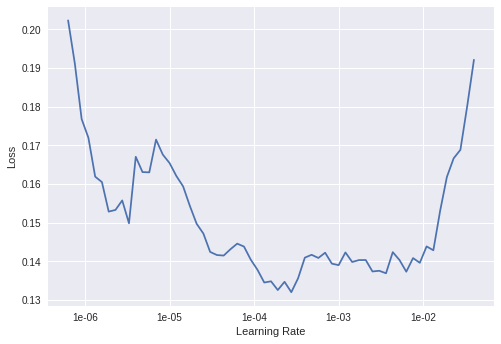

In [9]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(8, max_lr=slice(1e-05, 1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.132003,0.134824,0.951262,04:09
1,0.145300,0.135145,0.951262,04:09
2,0.156531,0.133641,0.952143,04:09
3,0.149135,0.134930,0.951556,04:09
4,0.144831,0.133700,0.952143,04:09
5,0.142808,0.131720,0.951262,04:09
6,0.138480,0.130894,0.951556,04:09
7,0.143064,0.132763,0.953318,04:09


In [0]:
learn.save('model_resnet50_places356_augment')

## Predict with TTA

In [12]:
tta_pred = learn.TTA(ds_type=DatasetType.Test)

## Generate submission file

In [0]:
image_name = pd.Series(os.listdir('train/test/'), name='image_name')
label = pd.Series(np.argmax(tta_pred[0], axis=1), name='label')
submission_df = pd.concat([image_name, label], axis=1)
submission_df.to_csv('submission_places365_tta.csv', index=False)